In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import datetime, timedelta

/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
model_name = 'ecmwfsipn'
model_type = 'reforecast'
no_day_change = 5


filepath_save = '/home/disk/sipn/mcmcgraw/data/VRILE/'
filename_full = filepath_save+'{model_name}_{model_type}_SIE_d_SIE_{d_days}day_change_lead_time_ALL_REGIONS_ALL_ENS.csv'.format(model_name=model_name,
                       model_type=model_type,d_days=no_day_change)
d_SIE = pd.read_csv(filename_full)
d_SIE_all = d_SIE.dropna()

In [67]:
regions = d_SIE_all['region'].unique().tolist() #list unique regions
lead_days = d_SIE_all['lead time (days)'].unique().tolist()
regions

['panArctic',
 'Sea of Okhotsk',
 'Bering',
 'Hudson Bay',
 'St John',
 'Baffin Bay',
 'East Greenland Sea',
 'Barents Sea',
 'Kara Sea',
 'Laptev Sea',
 'East Siberian Sea',
 'Chukchi Sea',
 'Beaufort Sea',
 'Canadian Islands',
 'Central Arctic',
 'Kara-Laptev',
 'East-Siberian-Beaufort-Chukchi']

In [123]:
region_choose = 'Kara-Laptev'
SIE_region_groups = d_SIE_all.groupby(['region'])
SIE_region_sel = SIE_region_groups.get_group(region_choose)
SIE_region_sel.head()

,Unnamed: 0,I (init date),V (valid date),SIE,lead time (days),d_SIE (V - I),ensemble,region
23220000,0,1993-01-01,1993-01-03,1.703407,2.0,0.0,1.0,Kara-Laptev
23220001,1,1993-01-01,1993-01-04,1.703407,3.0,0.0,1.0,Kara-Laptev
23220002,2,1993-01-01,1993-01-05,1.703407,4.0,0.0,1.0,Kara-Laptev
23220003,3,1993-01-01,1993-01-06,1.703407,5.0,0.0,1.0,Kara-Laptev
23220004,4,1993-01-01,1993-01-07,1.703407,6.0,0.0,1.0,Kara-Laptev


In [124]:
SIE_lead_groups = SIE_region_sel.groupby(['lead time (days)'])
lead_day_sel = 2
SIE_lead_sel = SIE_lead_groups.get_group(lead_day_sel)
SIE_model_dates = pd.to_datetime(SIE_lead_sel['V (valid date)'])

OBS

In [125]:
obs_name = 'NSIDC_0079'
obs_type = 'sipn_nc_yearly_agg'
obs_filename = '/home/disk/sipn/mcmcgraw/data/VRILE/{model_name}_{model_type}_SIE_d_SIE_{d_days}day_change_lead_time_ALL_REGIONS_ALL_ENS.csv'.format(model_name=obs_name,
                       model_type=obs_type,d_days=no_day_change)
SIE_obs = pd.read_csv(obs_filename)
SIE_obs = SIE_obs.dropna()
SIE_obs.head()

,Unnamed: 0,V (valid date),V_mon (valid date month),SIE,d_SIC (V - I),ensemble,region
0,0,1989-01-03,1.0,14.585865,0.130135,obs,panArctic
1,1,1989-01-04,1.0,14.595622,0.118162,obs,panArctic
2,2,1989-01-05,1.0,14.586416,0.073263,obs,panArctic
3,3,1989-01-06,1.0,14.622716,0.114523,obs,panArctic
4,4,1989-01-07,1.0,14.659128,0.239570,obs,panArctic


In [126]:
SIE_obs_dates = pd.to_datetime(SIE_obs['V (valid date)'])
SIE_model_day = SIE_model_dates.dt.day
SIE_obs_match_dates = SIE_obs.loc[pd.to_datetime(SIE_obs['V (valid date)']).dt.day==3]
SIE_obs_reg_group = SIE_obs_match_dates.groupby(['region'])
SIE_obs_reg_sel = SIE_obs_reg_group.get_group(region_choose)
SIE_obs_reg_sel.head()

,Unnamed: 0,V (valid date),V_mon (valid date month),SIE,d_SIC (V - I),ensemble,region
164355,0,1989-01-03,1.0,1.791022,0.0,obs,Kara-Laptev
164386,31,1989-02-03,2.0,1.791022,0.0,obs,Kara-Laptev
164414,59,1989-03-03,3.0,1.790389,0.0,obs,Kara-Laptev
164445,90,1989-04-03,4.0,1.791022,0.0,obs,Kara-Laptev
164475,120,1989-05-03,5.0,1.791022,0.0,obs,Kara-Laptev


In [127]:
yr_sel = np.arange(1994,2017)
bias_by_yr = pd.DataFrame(columns=["valid date (model)","valid month (model)","valid year (model)",
                                   "SIE ensemble mean (model)",
                                   "valid date (obs)","valid month (obs)","valid year (obs)",
                                   "SIE obs",
                                   "SIE bias (model - obs)"])
for iyr in yr_sel:
#iyr = 1994
    #save_ind = 
    SIE_obs_yr_sel = SIE_obs_reg_sel.loc[pd.to_datetime(SIE_obs_reg_sel['V (valid date)']).dt.year==iyr]
    SIE_model_yr_sel = SIE_lead_sel.loc[pd.to_datetime(SIE_lead_sel['V (valid date)']).dt.year==iyr]
    bias_by_iyr = pd.DataFrame(columns=["valid date (model)",
                                        "SIE ensemble mean (model)",
                                        "valid date (obs)",
                                        "SIE obs",
                                        "SIE bias (model - obs)"])

    bias_by_iyr['valid date (model)'] = SIE_model_yr_sel['V (valid date)'].unique().tolist()
    bias_by_iyr['valid month (model)'] = pd.to_datetime(SIE_model_yr_sel['V (valid date)']).dt.month.unique().tolist()
    bias_by_iyr['valid year (model)'] = np.tile(iyr,12)
    #
    bias_by_iyr['valid date (obs)'] = SIE_obs_yr_sel['V (valid date)'].unique().tolist()
    bias_by_iyr['valid month (obs)'] = pd.to_datetime(SIE_obs_yr_sel['V (valid date)']).dt.month.unique().tolist()
    bias_by_iyr['valid year (obs)'] = np.tile(iyr,12)
    #
    SIE_ens_mean = SIE_model_yr_sel.groupby(['V (valid date)']).mean()
    bias_by_iyr['SIE ensemble mean (model)'] = SIE_ens_mean['SIE'].values
    bias_by_iyr['SIE obs'] = SIE_obs_yr_sel['SIE'].values
    bias_by_iyr['SIE bias (model - obs)'] = SIE_ens_mean['SIE'].values - SIE_obs_yr_sel['SIE'].values
    if iyr == 1994:
        bias_by_yr = bias_by_iyr
    else:
        bias_by_yr = bias_by_yr.append(bias_by_iyr)

In [146]:
import seaborn as sns
bias_by_yr
fart = SIE_model_yr_sel.groupby(['V (valid date)']).max()
fart2 = SIE_model_yr_sel.groupby(['V (valid date)']).min()
fart3 = fart['SIE'] - fart2['SIE']
fart3
#SIE_ens_mean['SIE']
#fig1 = plt.figure(1)
#ax1=sns.boxplot(x='V (valid date)',y='SIE',data=SIE_lead_sel)
#ax1.set_xlabel('Month',fontsize=13)
#ax1.set_ylabel('Sea Ice Extent ($10^6 km^2$)',fontsize=13)
#ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
#ax1.set_title('{yr_choose} {title_var}, {region} ({model_name} {model_type}), lead days: {lead_day}'.format(yr_choose=yr_sel,title_var=titlename_choose_var,
#              region=region_sel,
#              model_name=model_name,model_type=model_type,lead_day=lead_ind_sel),fontsize=14)
#ax1.plot(np.arange(0,12),SIE_yr_sel['SIE'])

V (valid date)
2016-01-03    0.066066
2016-02-03    0.011650
2016-03-03    0.009746
2016-04-03    0.003250
2016-05-03    0.013436
2016-06-03    0.043756
2016-07-03    0.025188
2016-08-03    0.083467
2016-09-03    0.071448
2016-10-03    0.048046
2016-11-03    0.095469
2016-12-03    0.051321
Name: SIE, dtype: float64

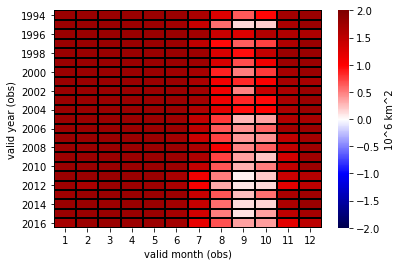

In [147]:
#SIE_dates = SIE_lead_sel.groupby('V (valid date)').mean()
#bias_2018 = SIE_dates['SIE'].values - SIE_yr_sel['SIE'].values
#SIE_obs_dates = SIE_obs_reg_sel.groupby(pd.to_datetime(SIE_obs_reg_sel['V (valid date)']).dt.month).mean()
#bias_obs_all = SIE_dates['SIE'].values - SIE_obs_dates['SIE'].values
obs_piv_plot = bias_by_yr.pivot(index='valid year (obs)',columns='valid month (obs)',values='SIE obs')
obs_piv_plot = obs_piv_plot.astype('float')
vmax = 2
ax6 = sns.heatmap(obs_piv_plot,vmin=-vmax,vmax=vmax,cmap='seismic',linewidths=1,
                  linecolor='k',cbar_kws={'label': '10^6 km^2',
                                          'ticks':np.linspace(-vmax,vmax,9)})

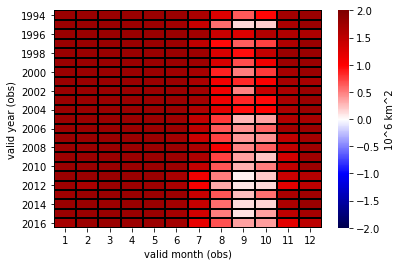

In [148]:
model_piv_plot = bias_by_yr.pivot(index='valid year (model)',columns='valid month (model)',values='SIE ensemble mean (model)')
model_piv_plot = model_piv_plot.astype('float')
ax7 = sns.heatmap(obs_piv_plot,vmin=-vmax,vmax=vmax,cmap='seismic',linewidths=1,
                  linecolor='k',cbar_kws={'label': '10^6 km^2',
                                          'ticks':np.linspace(-vmax,vmax,9)})

Text(0.5, 1.0, 'SIE bias (model - obs)')

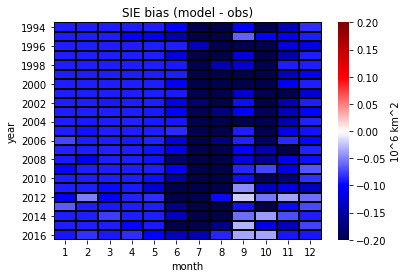

In [136]:
diff_piv_plot = model_piv_plot - obs_piv_plot
ax8 = sns.heatmap(diff_piv_plot,vmin=-vmax/10,vmax=vmax/10,cmap='seismic',linewidths=1,
                  linecolor='k',cbar_kws={'label': '10^6 km^2',
                                          'ticks':np.linspace(-vmax/10,vmax/10,9)})
ax8.set_xlabel('month')
ax8.set_ylabel('year')
ax8.set_title('SIE bias (model - obs)')

In [110]:
diff_piv_plot

valid month (model),1,2,3,4,5,6,7,8,9,10,11,12
valid year (model),,,,,,,,,,,,
1994,-0.161539,-0.116949,-0.241875,-0.199700,-0.148189,-0.083996,0.029074,0.0,0.0,0.0,0.000000,-0.246187
1995,-0.108205,-0.185688,-0.184848,-0.152349,-0.008357,0.068312,0.003591,0.0,0.0,0.0,0.000000,0.012906
1996,-0.160388,-0.099283,-0.144557,-0.123529,-0.067242,-0.045624,0.000000,0.0,0.0,0.0,0.000000,-0.054462
1997,-0.258838,-0.309797,-0.126352,-0.209161,-0.128688,-0.026236,0.000000,0.0,0.0,0.0,0.000000,-0.066244
1998,-0.154079,-0.082008,-0.116775,-0.151721,-0.065565,-0.102120,0.000000,0.0,0.0,0.0,0.000000,-0.299675
1999,-0.247377,-0.182538,-0.045533,-0.164729,-0.103487,-0.093073,0.011483,0.0,0.0,0.0,0.000000,-0.133580
2000,-0.281052,-0.090620,-0.118287,-0.140012,-0.102300,-0.075323,0.000000,0.0,0.0,0.0,0.000000,-0.320782
2001,-0.282199,-0.122780,-0.098431,-0.209975,-0.137044,-0.068174,0.024717,0.0,0.0,0.0,0.000000,-0.238029
2002,-0.213202,-0.224267,-0.177591,-0.129776,-0.081081,-0.088155,0.000000,0.0,0.0,0.0,0.000000,-0.091865
